In [17]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from collections import defaultdict
from scipy.stats import kstest, norm, uniform, beta, expon, truncnorm

from scipy.optimize import brentq

from tqdm import tqdm
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
import sdv
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import evaluate_quality
from sdv.single_table import GaussianCopulaSynthesizer
tqdm.pandas()
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings(action='ignore')
import seaborn as sns

In [2]:
data = pd.read_csv('American_Income.csv')

In [3]:
data_info = data.dtypes.to_dict()
num_column = []
category_column = []
for key in data_info.keys():
    if data_info[key] == 'int64':
        num_column.append(key)
    if data_info[key] == 'object':
        category_column.append(key)

In [4]:
## all functions

def findBestComp(data):
    bic = []
    n_components_range = range(1, 11)
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(data.values.reshape(-1, 1))
        bic.append(gmm.bic(data.values.reshape(-1, 1)))

    optimal_components = n_components_range[np.argmin(bic)]

    return optimal_components


def gmm_cdf(x, gmm):
    """
    Compute the CDF of the GMM at point x.
    
    Parameters:
    - x: Point at which to evaluate the CDF
    - gmm: Fitted GaussianMixture object
    
    Returns:
    - CDF value at point x
    """
    cdf_value = 0
    for weight, mean, covariance in zip(gmm.weights_, gmm.means_, gmm.covariances_):
        cdf_value += weight * stats.norm.cdf(x, mean, np.sqrt(covariance)) 
    return cdf_value[0][0]


def gaussian_inverse_cdf(p_values):
    return norm.ppf(p_values)


def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    """ Return a truncated normal distribution. """
    return truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

def assign_intervals(categories):
    """ Assign intervals to categories based on their frequency. """
    freq = categories.value_counts(normalize=True)
    intervals = freq.cumsum()
    category_intervals = {}
    a = 0
    for category, cum_freq in intervals.items():
        b = cum_freq
        category_intervals[category] = (a, b)
        a = b
    return category_intervals

def sample_from_category(category, category_intervals):
    """ Sample a numerical value for a given category. """
    a, b = category_intervals[category]
    mean = (a + b) / 2
    sd = (b - a) / 6
    dist = get_truncated_normal(mean, sd, a, b)
    return dist.rvs()


def gmm_cdf_dict(x, gmm):
    """
    Compute the CDF of the GMM at point x using a dictionary to represent the GMM parameters.
    
    Parameters:
    - x: Point at which to evaluate the CDF
    - gmm: Dictionary with GMM parameters
    
    Returns:
    - CDF value at point x
    """
    cdf_value = 0
    for weight, mean, covariance in zip(gmm['weights_'], gmm['means_'], gmm['covariances_']):
        cdf_value += weight * norm.cdf(x, mean, np.sqrt(covariance))
    return cdf_value

def check_cdf_bounds(gmm, bounds, probabilities):
    results = []
    for p in probabilities:
        cdf_lower = gmm_cdf_dict(bounds[0], gmm)
        cdf_upper = gmm_cdf_dict(bounds[1], gmm)
        results.append((p, cdf_lower, cdf_upper, np.sign(cdf_lower - p), np.sign(cdf_upper - p)))
    return results


def compute_gmm_bounds(gmm, num_std=3):
    """
    Compute bounds for the GMM based on standard deviations from the mean.
    
    Parameters:
    - gmm: Dictionary with GMM parameters
    - num_std: Number of standard deviations to use for bounds
    
    Returns:
    - A tuple (lower_bound, upper_bound)
    """
    means = gmm['means_'].flatten()
    stds = np.sqrt(gmm['covariances_'].flatten())
    
    lower_bounds = means - num_std * stds
    upper_bounds = means + num_std * stds
    
    lower_bound = min(lower_bounds)
    upper_bound = max(upper_bounds)
    
    return lower_bound, upper_bound

def sample(F_inv, Sigma):
    """
    Sample numerical values from the distribution and covariances of the columns.
    
    Parameters:
    - F_inv: A list of inverse CDF functions for the marginals.
    - Sigma: The covariance matrix.
    
    Returns:
    - A sample vector x in the original space.
    """
    # Step 2: Random n-dimensional Gaussian vector
    n = Sigma.shape[0]
    v = np.random.randn(n)
    
    # Step 3: Cholesky decomposition
    L = np.linalg.cholesky(Sigma)
    
    # Step 4: u ← Lv
    u = L.dot(v)
    
    # Step 5: x ← [F_0^(-1)(Φ(u_0)), F_1^(-1)(Φ(u_1)), ..., F_n^(-1)(Φ(u_n))]
    x = [F_inv_i(norm.cdf(u_i)) for F_inv_i, u_i in zip(F_inv, u)]
    
    return x



In [5]:
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [6]:
category_column

[' workclass',
 ' education',
 ' marital-status',
 ' occupation',
 ' relationship',
 ' race',
 ' sex',
 ' native-country',
 ' salary']

In [7]:
num_column #eduaction_num belongs to category

['age',
 ' fnlwgt',
 ' education-num',
 ' capital-gain',
 ' capital-loss',
 ' hours-per-week']

In [8]:
age_components = findBestComp(data['age'])

fnlwgt_components = findBestComp(data[' fnlwgt'])

gain_components = findBestComp(data[' capital-gain'])

loss_components = findBestComp(data[' capital-loss'])

hours_components = findBestComp(data[' hours-per-week'])

  File "c:\Users\10063\AppData\Local\Programs\Python\Python38\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [9]:
#inital the gmm to fit
gmm_age = GaussianMixture(n_components=age_components)
gmm_age.fit(data['age'].values.reshape(-1, 1))

# Fit a GMM to the 'hours-per-week' column
gmm_hours = GaussianMixture(n_components=hours_components)  
gmm_hours.fit(data[' hours-per-week'].values.reshape(-1, 1))

gmm_fnlwgt = GaussianMixture(n_components=fnlwgt_components)
gmm_fnlwgt.fit(data[' fnlwgt'].values.reshape(-1, 1))

gmm_gain = GaussianMixture(n_components=gain_components)
gmm_gain.fit(data[' capital-gain'].values.reshape(-1, 1))

gmm_loss = GaussianMixture(n_components=loss_components)
gmm_loss.fit(data[' capital-loss'].values.reshape(-1, 1))

GaussianMixture(n_components=9)

In [10]:
categories_workclass = data[' workclass']
category_intervals_workclass = assign_intervals(categories_workclass)
numerical_values_workclass = categories_workclass.apply(lambda x: sample_from_category(x, category_intervals_workclass))

categories_education = data[' education']
category_intervals_education = assign_intervals(categories_education)
numerical_values_education = categories_education.apply(lambda x: sample_from_category(x, category_intervals_education))

categories_marital = data[' marital-status']
category_intervals_marital = assign_intervals(categories_marital)
numerical_values_marital = categories_marital.apply(lambda x: sample_from_category(x, category_intervals_marital))

categories_occupation = data[' occupation']
category_intervals_occupation = assign_intervals(categories_occupation)
numerical_values_occupation = categories_occupation.apply(lambda x: sample_from_category(x, category_intervals_occupation))

categories_relationship = data[' relationship']
category_intervals_relationship = assign_intervals(categories_relationship)
numerical_values_relationship = categories_relationship.apply(lambda x: sample_from_category(x, category_intervals_relationship))

categories_race = data[' race']
category_intervals_race = assign_intervals(categories_race)
numerical_values_race = categories_race.apply(lambda x: sample_from_category(x, category_intervals_race))

categories_sex = data[' sex']
category_intervals_sex = assign_intervals(categories_sex)
numerical_values_sex = categories_sex.apply(lambda x: sample_from_category(x, category_intervals_sex))

categories_country = data[' native-country']
category_intervals_country = assign_intervals(categories_country)
numerical_values_country = categories_country.apply(lambda x: sample_from_category(x, category_intervals_country))

categories_salary = data[' salary']
category_intervals_salary = assign_intervals(categories_salary)
numerical_values_salary = categories_salary.apply(lambda x: sample_from_category(x, category_intervals_salary))

In [11]:
data[' workclass'] = numerical_values_workclass
data[' education'] = numerical_values_education
data[' marital-status'] = numerical_values_marital
data[' occupation'] = numerical_values_occupation
data[' relationship'] = numerical_values_relationship
data[' race'] = numerical_values_race
data[' sex'] = numerical_values_sex
data[' native-country'] = numerical_values_country
data[' salary'] = numerical_values_salary

In [12]:
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,0.924838,77516,0.624081,13,0.503013,0.445255,0.509846,0.291901,0.214353,2174,0,40,0.116862,0.471690
1,50,0.735012,83311,0.595048,13,0.248069,0.302815,0.269224,0.659203,0.338812,0,0,13,0.273172,0.591009
2,38,0.101615,215646,0.154631,9,0.883207,0.898621,0.540031,0.338776,0.272284,0,0,40,0.099658,0.548400
3,53,0.398047,234721,0.824372,7,0.198636,0.894224,0.220105,0.887613,0.282451,0,0,40,0.069251,0.429520
4,28,0.228840,338409,0.621892,13,0.293063,0.083561,0.942580,0.908050,0.845571,0,0,40,0.959188,0.388084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,0.266774,257302,0.866508,12,0.078666,0.966933,0.947671,0.340422,0.884271,0,0,38,0.565328,0.302744
32557,40,0.285552,154374,0.221153,9,0.310892,0.733007,0.310516,0.359242,0.418839,0,0,40,0.311406,0.888530
32558,58,0.283649,151910,0.101419,9,0.980670,0.426153,0.872524,0.351872,0.814166,0,0,40,0.525236,0.335597
32559,22,0.277259,201490,0.098205,9,0.587973,0.414748,0.723720,0.294087,0.225774,0,0,20,0.429884,0.207846


In [13]:
workclass_components = findBestComp(data[' workclass'])

education_components = findBestComp(data[' education'])

marital_components = findBestComp(data[' marital-status'])

occupation_components = findBestComp(data[' occupation'])

relationship_components = findBestComp(data[' relationship'])

race_components = findBestComp(data[' race'])

sex_components = findBestComp(data[' sex'])

country_components = findBestComp(data[' native-country'])

salary_components = findBestComp(data[' salary'])

In [14]:
gmm_workclass = GaussianMixture(n_components=workclass_components)
gmm_workclass.fit(data[' workclass'].values.reshape(-1, 1))

gmm_education = GaussianMixture(n_components=education_components)
gmm_education.fit(data[' education'].values.reshape(-1, 1))

gmm_marital = GaussianMixture(n_components=marital_components)
gmm_marital.fit(data[' marital-status'].values.reshape(-1, 1))

gmm_occupation = GaussianMixture(n_components=occupation_components)
gmm_occupation.fit(data[' occupation'].values.reshape(-1, 1))

gmm_relationship = GaussianMixture(n_components= relationship_components)
gmm_relationship.fit(data[' relationship'].values.reshape(-1, 1))

gmm_race = GaussianMixture(n_components=race_components)
gmm_race.fit(data[' race'].values.reshape(-1, 1))

gmm_sex = GaussianMixture(n_components=sex_components)
gmm_sex.fit(data[' sex'].values.reshape(-1, 1))

gmm_country = GaussianMixture(n_components=country_components)
gmm_country.fit(data[' native-country'].values.reshape(-1, 1))

gmm_salary = GaussianMixture(n_components=salary_components)
gmm_salary.fit(data[' salary'].values.reshape(-1, 1))

GaussianMixture(n_components=2)

In [15]:
GMM_cdf_table = pd.DataFrame()
GMM_cdf_table['age'] = data['age'].apply(lambda x: gmm_cdf(x, gmm_age))
GMM_cdf_table[' workclass'] = data[' workclass'].apply(lambda x: gmm_cdf(x, gmm_workclass))
GMM_cdf_table[' fnlwgt'] = data[' fnlwgt'].apply(lambda x: gmm_cdf(x, gmm_fnlwgt))
GMM_cdf_table[' education'] = data[' education'].apply(lambda x: gmm_cdf(x, gmm_education))
GMM_cdf_table[' marital-status'] = data[' marital-status'].apply(lambda x: gmm_cdf(x, gmm_marital))
GMM_cdf_table[' occupation'] = data[' occupation'].apply(lambda x: gmm_cdf(x, gmm_occupation))
GMM_cdf_table[' relationship'] = data[' relationship'].apply(lambda x: gmm_cdf(x, gmm_relationship))
GMM_cdf_table[' race'] = data[' race'].apply(lambda x: gmm_cdf(x, gmm_race))
GMM_cdf_table[' sex'] = data[' sex'].apply(lambda x: gmm_cdf(x, gmm_sex))
GMM_cdf_table[' capital-gain'] = data[' capital-gain'].apply(lambda x: gmm_cdf(x, gmm_gain))
GMM_cdf_table[' capital-loss'] = data[' capital-loss'].apply(lambda x: gmm_cdf(x, gmm_loss))
GMM_cdf_table[' hours-per-week'] = data[' hours-per-week'].apply(lambda x: gmm_cdf(x, gmm_hours))
GMM_cdf_table[' native-country'] = data[' native-country'].apply(lambda x: gmm_cdf(x, gmm_country))
GMM_cdf_table[' salary'] = data[' salary'].apply(lambda x: gmm_cdf(x, gmm_salary))


In [16]:
GMM_invers_cdf_table = pd.DataFrame()

GMM_invers_cdf_table['age'] = GMM_cdf_table['age'].apply(lambda x: gaussian_inverse_cdf(x))
GMM_invers_cdf_table[' workclass'] = GMM_cdf_table[' workclass'].apply(lambda x: gaussian_inverse_cdf(x))
GMM_invers_cdf_table[' fnlwgt'] = GMM_cdf_table[' fnlwgt'].apply(lambda x: gaussian_inverse_cdf(x))
GMM_invers_cdf_table[' education'] = GMM_cdf_table[' education'].apply(lambda x: gaussian_inverse_cdf(x))
GMM_invers_cdf_table[' marital-status'] = GMM_cdf_table[' marital-status'].apply(lambda x: gaussian_inverse_cdf(x))
GMM_invers_cdf_table[' occupation'] = GMM_cdf_table[' occupation'].apply(lambda x: gaussian_inverse_cdf(x))
GMM_invers_cdf_table[' relationship'] = GMM_cdf_table[' relationship'].apply(lambda x: gaussian_inverse_cdf(x))
GMM_invers_cdf_table[' race'] = GMM_cdf_table[' race'].apply(lambda x: gaussian_inverse_cdf(x))
GMM_invers_cdf_table[' sex'] = GMM_cdf_table[' sex'].apply(lambda x: gaussian_inverse_cdf(x))
GMM_invers_cdf_table[' capital-gain'] = GMM_cdf_table[' capital-gain'].apply(lambda x: gaussian_inverse_cdf(x))
GMM_invers_cdf_table[' capital-loss'] = GMM_cdf_table[' capital-loss'].apply(lambda x: gaussian_inverse_cdf(x))
GMM_invers_cdf_table[' hours-per-week'] = GMM_cdf_table[' hours-per-week'].apply(lambda x: gaussian_inverse_cdf(x))
GMM_invers_cdf_table[' native-country'] = GMM_cdf_table[' native-country'].apply(lambda x: gaussian_inverse_cdf(x))
GMM_invers_cdf_table[' salary'] = GMM_cdf_table[' salary'].apply(lambda x: gaussian_inverse_cdf(x))


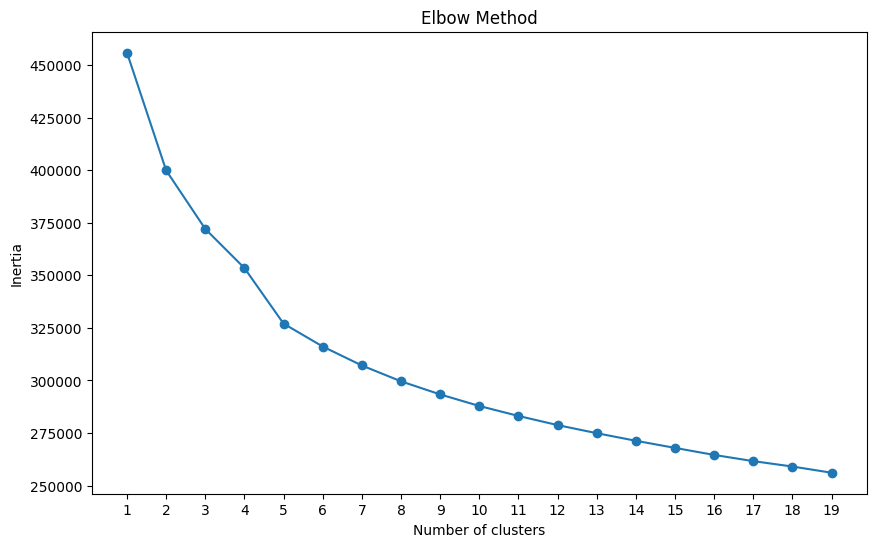

In [19]:
## KMeans Applies Here
scaler = StandardScaler()
scaled_data = scaler.fit_transform(GMM_invers_cdf_table)

# Applying the Elbow method to find the optimal number of clusters
inertia = []
range_of_clusters = range(1, 20)

for k in range_of_clusters:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range_of_clusters, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range_of_clusters)
plt.show()

In [20]:
# covariance_matrix = GMM_invers_cdf_table.cov()
num_of_cluster = 4


kmeans = KMeans(n_clusters=num_of_cluster, random_state=0)
kmeans.fit(GMM_invers_cdf_table)
labels = kmeans.labels_
GMM_invers_cdf_table['label'] = labels
GMM_invers_cdf_table

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,label
0,0.129073,1.458664,-1.169204,0.294658,-0.090179,-0.105988,-0.043915,-1.058058,-1.340610,1.43555,-0.058451,-0.067801,-2.295579,0.214439,1
1,0.811116,0.626002,-1.119863,0.164495,-0.612654,-0.561299,-0.420319,0.881106,-0.403390,-0.10440,-0.058451,-1.905164,-1.253367,0.598588,0
2,0.058852,-2.296363,0.489948,-1.049828,1.334529,1.290583,0.119271,-0.746399,-0.881571,-0.10440,-0.058451,-0.067801,-2.411149,0.503325,3
3,1.002845,-0.082621,0.672290,0.925594,-0.987527,1.266692,-0.682691,1.157041,-0.804425,-0.10440,-0.058451,-0.067801,-2.615682,-0.003993,0
4,-0.638251,-1.251244,1.372134,0.282400,-0.353439,-1.249429,1.529919,1.281239,1.077036,-0.10440,-0.058451,-0.067801,1.791819,-0.250000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,-0.726451,-0.963650,0.818653,1.118102,-2.375553,1.895564,1.579762,-0.736827,1.549837,-0.10440,-0.058451,-0.755303,0.542195,-0.821594,3
32557,0.196020,-0.835163,-0.283356,-0.585056,-0.275931,0.603789,-0.299258,-0.626251,0.051474,-0.10440,-0.058451,-0.067801,-1.001893,1.281797,0
32558,1.289240,-0.848548,-0.308100,-1.686291,2.186233,-0.217588,1.165129,-0.670228,0.786277,-0.10440,-0.058451,-0.067801,0.326798,-0.593642,2
32559,-1.243274,-0.892646,0.309034,-1.730018,0.107874,-0.268922,0.543689,-1.041535,-1.247890,-0.10440,-0.058451,-1.471805,-0.241485,-1.513968,3


In [22]:
centroids = kmeans.cluster_centers_

gmm_overall = GaussianMixture(n_components=num_of_cluster, covariance_type='full', random_state=0)

gmm_overall.means_init = centroids ## Initial the means to let the apply components on different cluster

gmm_overall.fit(GMM_invers_cdf_table.iloc[:,0:14])

GaussianMixture(means_init=array([[ 0.37433722,  0.01528035, -0.09352161, -0.31146272, -0.75912225,
         0.50231188, -0.86365889, -0.09046145, -0.61681827, -0.00381821,
         0.02291056,  0.18095876, -0.04667313, -0.27525852],
       [ 0.4053578 ,  0.16284511,  0.0186746 ,  0.41237827, -0.68147206,
        -0.75243965, -0.72919914, -0.12307111, -0.48975017,  0.31010285,
         0.14812004,  0.54653404,  0.00909283,  1.04...
       [ 0.45465861,  0.1157137 , -0.22861928, -0.04099426,  0.92787747,
        -0.1720029 ,  0.69254332,  0.14422063,  0.8000592 ,  0.01469619,
         0.02047197, -0.1094419 ,  0.01407638, -0.21906158],
       [-1.05544698, -0.25203027,  0.27302458, -0.03929799,  0.32317453,
         0.35173382,  0.66391816,  0.0412178 ,  0.16571429, -0.0579044 ,
        -0.00857345, -0.49012163,  0.01825526, -0.41366119]]),
                n_components=4, random_state=0)

In [23]:
cluster_summary = GMM_invers_cdf_table.groupby('label').agg(['mean', 'median', 'std'])

cluster_summary

age                      workclass                        fnlwgt  \
           mean    median       std       mean    median       std      mean   
label                                                                          
0      0.373140  0.256812  0.842436   0.014755  0.055626  0.982120 -0.093025   
1      0.405830  0.372476  0.700457   0.162690  0.150483  1.045629  0.018747   
2      0.455723  0.372476  0.793671   0.116798  0.114973  0.990293 -0.227539   
3     -1.055318 -0.993668  0.660863  -0.252340 -0.248248  0.934108  0.271382   

                           education  ...  capital-loss  hours-per-week  \
         median       std       mean  ...           std            mean   
label                                 ...                                 
0     -0.071584  0.994750  -0.312278  ...      0.412824        0.181748   
1     -0.004893  0.977212   0.412327  ...      0.651781        0.545606   
2     -0.212093  0.943950  -0.039896  ...      0.414421       -0.107231   
3      0.287717  1.000472  -0.039567  ...      0.314687       -0.491967   

                           native-country                        salary  \
         median       std            mean    median       std      mean   
label                                                                     
0     -0.067801  0.928528       -0.047088 -0.046578  0.973714 -0.275660   
1      0.677399  0.843673        0.008918  0.012384  0.998454  1.044273   
2     -0.067801  0.908100        0.014672  0.016104  1.012613 -0.219298   
3     -0.067801  0.867022        0.018195  0.014785  1.007636 -0.413199   

                           
         median       std  
label                      
0     -0.260620  0.912556  
1      1.037269  0.726787  
2     -0.172824  0.857791  
3     -0.322874  0.777752  

[4 rows x 42 columns]

In [24]:
synthetic_overall = gmm_overall.sample(len(GMM_invers_cdf_table))[0]

column_names = ['age', ' workclass', ' fnlwgt', ' education', ' marital-status', ' occupation', ' relationship', ' race',
                                                             ' sex', ' capital-gain', ' capital-loss', ' hours-per-week', ' native-country', ' salary']
synthetic_overall_df = pd.DataFrame(synthetic_overall, columns=column_names)


synthetic_overall_df

covariance_matrix = synthetic_overall_df.cov()

In [25]:
gmm_age_dict = {
    'weights_': gmm_age.weights_, 
    'means_': gmm_age.means_, 
    'covariances_': gmm_age.covariances_ 
}
gmm_workclass_dict = {
    'weights_': gmm_workclass.weights_, 
    'means_': gmm_workclass.means_, 
    'covariances_': gmm_workclass.covariances_ 
}
gmm_fnlwgt_dict = {
    'weights_': gmm_fnlwgt.weights_, 
    'means_': gmm_fnlwgt.means_, 
    'covariances_': gmm_fnlwgt.covariances_ 
}
gmm_education_dict = {
    'weights_': gmm_education.weights_, 
    'means_': gmm_education.means_, 
    'covariances_': gmm_education.covariances_ 
}
gmm_marital_dict = {
    'weights_': gmm_marital.weights_, 
    'means_': gmm_marital.means_, 
    'covariances_': gmm_marital.covariances_ 
}
gmm_occupation_dict = {
    'weights_': gmm_occupation.weights_, 
    'means_': gmm_occupation.means_, 
    'covariances_': gmm_occupation.covariances_ 
}
gmm_relationship_dict = {
    'weights_': gmm_relationship.weights_, 
    'means_': gmm_relationship.means_, 
    'covariances_': gmm_relationship.covariances_ 
}
gmm_race_dict = {
    'weights_': gmm_race.weights_, 
    'means_': gmm_race.means_, 
    'covariances_': gmm_race.covariances_ 
}
gmm_sex_dict = {
    'weights_': gmm_sex.weights_, 
    'means_': gmm_sex.means_, 
    'covariances_': gmm_sex.covariances_ 
}
gmm_gain_dict = {
    'weights_': gmm_gain.weights_, 
    'means_': gmm_gain.means_, 
    'covariances_': gmm_gain.covariances_ 
}
gmm_loss_dict = {
    'weights_': gmm_loss.weights_, 
    'means_': gmm_loss.means_, 
    'covariances_': gmm_loss.covariances_ 
}
gmm_country_dict = {
    'weights_': gmm_country.weights_, 
    'means_': gmm_country.means_, 
    'covariances_': gmm_country.covariances_ 
}
gmm_salary_dict = {
    'weights_': gmm_salary.weights_, 
    'means_': gmm_salary.means_, 
    'covariances_': gmm_salary.covariances_ 
}

gmm_hours_dict = {
    'weights_': gmm_hours.weights_,
    'means_': gmm_hours.means_, 
    'covariances_': gmm_hours.covariances_  
}


age_bounds = (synthetic_overall_df['age'].min(), synthetic_overall_df['age'].max())
workclass_bounds = (synthetic_overall_df[' workclass'].min(), synthetic_overall_df[' workclass'].max())
fnlwgt_bounds = (synthetic_overall_df[' fnlwgt'].min(), synthetic_overall_df[' fnlwgt'].max())
education_bounds = (synthetic_overall_df[' education'].min(), synthetic_overall_df[' education'].max())
marital_bounds = (synthetic_overall_df[' marital-status'].min(), synthetic_overall_df[' marital-status'].max())
occupation_bounds = (synthetic_overall_df[' occupation'].min(), synthetic_overall_df[' occupation'].max())
relationship_bounds = (synthetic_overall_df[' relationship'].min(), synthetic_overall_df[' relationship'].max())
race_bounds = (synthetic_overall_df[' race'].min(), synthetic_overall_df[' race'].max())
sex_bounds = (synthetic_overall_df[' sex'].min(), synthetic_overall_df[' sex'].max())
gain_bounds = (synthetic_overall_df[' capital-gain'].min(), synthetic_overall_df[' capital-gain'].max())
loss_bounds = (synthetic_overall_df[' capital-loss'].min(), synthetic_overall_df[' capital-loss'].max())
country_bounds = (synthetic_overall_df[' native-country'].min(), synthetic_overall_df[' native-country'].max())
salary_bounds = (synthetic_overall_df[' salary'].min(), synthetic_overall_df[' salary'].max())
hours_bounds = (synthetic_overall_df[' hours-per-week'].min(), synthetic_overall_df[' hours-per-week'].max())   
probabilities = [0.1, 0.5, 0.9]

age_cdf_check = check_cdf_bounds(gmm_age_dict, age_bounds, probabilities)
workclass_cdf_check = check_cdf_bounds(gmm_workclass_dict, workclass_bounds, probabilities)
fnlwgt_cdf_check = check_cdf_bounds(gmm_fnlwgt_dict, fnlwgt_bounds, probabilities)
education_cdf_check = check_cdf_bounds(gmm_education_dict, education_bounds, probabilities)
marital_cdf_check = check_cdf_bounds(gmm_marital_dict, marital_bounds, probabilities)
occupation_cdf_check = check_cdf_bounds(gmm_occupation_dict, occupation_bounds, probabilities)
relationship_cdf_check = check_cdf_bounds(gmm_relationship_dict, relationship_bounds, probabilities)
race_cdf_check = check_cdf_bounds(gmm_race_dict, race_bounds, probabilities)
sex_cdf_check = check_cdf_bounds(gmm_sex_dict, sex_bounds, probabilities)
gain_cdf_check = check_cdf_bounds(gmm_gain_dict, gain_bounds, probabilities)
loss_cdf_check = check_cdf_bounds(gmm_loss_dict, loss_bounds, probabilities)
country_cdf_check = check_cdf_bounds(gmm_country_dict, country_bounds, probabilities)
salary_cdf_check = check_cdf_bounds(gmm_salary_dict, salary_bounds, probabilities)
hours_cdf_check = check_cdf_bounds(gmm_hours_dict, hours_bounds, probabilities)
# (age_cdf_check, hours_cdf_check)

In [26]:
new_age_bounds = compute_gmm_bounds(gmm_age_dict)
new_workclass_bounds = compute_gmm_bounds(gmm_workclass_dict)
new_fnlwgt_bounds = compute_gmm_bounds(gmm_fnlwgt_dict)
new_marital_bounds = compute_gmm_bounds(gmm_marital_dict)
new_education_bounds = compute_gmm_bounds(gmm_education_dict)
new_occupation_bounds = compute_gmm_bounds(gmm_occupation_dict)
new_relationship_bounds = compute_gmm_bounds(gmm_relationship_dict)
new_race_bounds = compute_gmm_bounds(gmm_race_dict)
new_sex_bounds = compute_gmm_bounds(gmm_sex_dict)
new_gain_bounds = compute_gmm_bounds(gmm_gain_dict)
new_loss_bounds = compute_gmm_bounds(gmm_loss_dict)
new_country_bounds = compute_gmm_bounds(gmm_country_dict)
new_salary_bounds = compute_gmm_bounds(gmm_salary_dict)
new_hours_bounds = compute_gmm_bounds(gmm_hours_dict)

# # Check the new CDF values at the computed bounds
# new_age_cdf_check = check_cdf_bounds(gmm_age_dict, new_age_bounds, probabilities)
# new_hours_cdf_check = check_cdf_bounds(gmm_hours_dict, new_hours_bounds, probabilities)

In [27]:
def inverse_cdf_gmm_age(p):
    lower_bound, upper_bound = new_age_bounds
    for _ in range(5):
        f_lower = gmm_cdf(lower_bound, gmm_age) - p
        f_upper = gmm_cdf(upper_bound, gmm_age) - p
        # Check if the signs are different
        if np.sign(f_lower) != np.sign(f_upper):
            try:
                return brentq(lambda x: gmm_cdf(x, gmm_age) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)
            except ValueError as e:
                print(f"Failed to converge for p={p} with bounds ({lower_bound}, {upper_bound}): {e}")
                return np.nan  # or some other sentinel value indicating failure
        else:
            # Adjust the bounds
            lower_bound *= 0.9  # shrink the bounds
            upper_bound *= 1.1  # expand the bounds
    print(f"Failed to find valid bounds for p={p} after {5} retries")
    return np.nan  # or some other sentinel value indicating failure

def inverse_cdf_gmm_workclass(p):
    lower_bound, upper_bound = new_workclass_bounds
    for _ in range(5):
        f_lower = gmm_cdf(lower_bound, gmm_workclass) - p
        f_upper = gmm_cdf(upper_bound, gmm_workclass) - p
        # Check if the signs are different
        if np.sign(f_lower) != np.sign(f_upper):
            try:
                return brentq(lambda x: gmm_cdf(x, gmm_workclass) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)
            except ValueError as e:
                print(f"Failed to converge for p={p} with bounds ({lower_bound}, {upper_bound}): {e}")
                return np.nan  # or some other sentinel value indicating failure
        else:
            # Adjust the bounds
            lower_bound *= 0.9  # shrink the bounds
            upper_bound *= 1.1  # expand the bounds
    print(f"Failed to find valid bounds for p={p} after {5} retries")
    return np.nan  # or some other sentinel value indicating failure

def inverse_cdf_gmm_fnlwgt(p):
    lower_bound, upper_bound = new_fnlwgt_bounds
    for _ in range(5):
        f_lower = gmm_cdf(lower_bound, gmm_fnlwgt) - p
        f_upper = gmm_cdf(upper_bound, gmm_fnlwgt) - p
        # Check if the signs are different
        if np.sign(f_lower) != np.sign(f_upper):
            try:
                return brentq(lambda x: gmm_cdf(x, gmm_fnlwgt) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)
            except ValueError as e:
                print(f"Failed to converge for p={p} with bounds ({lower_bound}, {upper_bound}): {e}")
                return np.nan  # or some other sentinel value indicating failure
        else:
            # Adjust the bounds
            lower_bound *= 0.9  # shrink the bounds
            upper_bound *= 1.1  # expand the bounds
    print(f"Failed to find valid bounds for p={p} after {5} retries")
    return np.nan  # or some other sentinel value indicating failure

def inverse_cdf_gmm_education(p):
    lower_bound, upper_bound = new_education_bounds
    for _ in range(5):
        f_lower = gmm_cdf(lower_bound, gmm_education) - p
        f_upper = gmm_cdf(upper_bound, gmm_education) - p
        # Check if the signs are different
        if np.sign(f_lower) != np.sign(f_upper):
            try:
                return brentq(lambda x: gmm_cdf(x, gmm_education) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)
            except ValueError as e:
                print(f"Failed to converge for p={p} with bounds ({lower_bound}, {upper_bound}): {e}")
                return np.nan  # or some other sentinel value indicating failure
        else:
            # Adjust the bounds
            lower_bound *= 0.9  # shrink the bounds
            upper_bound *= 1.1  # expand the bounds
    print(f"Failed to find valid bounds for p={p} after {5} retries")
    return np.nan  # or some other sentinel value indicating failure


def inverse_cdf_gmm_marital(p):
    lower_bound, upper_bound = new_marital_bounds
    for _ in range(5):
        f_lower = gmm_cdf(lower_bound, gmm_marital) - p
        f_upper = gmm_cdf(upper_bound, gmm_marital) - p
        # Check if the signs are different
        if np.sign(f_lower) != np.sign(f_upper):
            try:
                return brentq(lambda x: gmm_cdf(x, gmm_marital) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)
            except ValueError as e:
                print(f"Failed to converge for p={p} with bounds ({lower_bound}, {upper_bound}): {e}")
                return np.nan  # or some other sentinel value indicating failure
        else:
            # Adjust the bounds
            lower_bound *= 0.9  # shrink the bounds
            upper_bound *= 1.1  # expand the bounds
    print(f"Failed to find valid bounds for p={p} after {5} retries")
    return np.nan  # or some other sentinel value indicating failure


def inverse_cdf_gmm_occupation(p):
    lower_bound, upper_bound = new_occupation_bounds
    for _ in range(5):
        f_lower = gmm_cdf(lower_bound, gmm_occupation) - p
        f_upper = gmm_cdf(upper_bound, gmm_occupation) - p
        # Check if the signs are different
        if np.sign(f_lower) != np.sign(f_upper):
            try:
                return brentq(lambda x: gmm_cdf(x, gmm_occupation) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)
            except ValueError as e:
                print(f"Failed to converge for p={p} with bounds ({lower_bound}, {upper_bound}): {e}")
                return np.nan  # or some other sentinel value indicating failure
        else:
            # Adjust the bounds
            lower_bound *= 0.9  # shrink the bounds
            upper_bound *= 1.1  # expand the bounds
    print(f"Failed to find valid bounds for p={p} after {5} retries")
    return np.nan  # or some other sentinel value indicating failure


def inverse_cdf_gmm_relationship(p):
    lower_bound, upper_bound = new_relationship_bounds
    for _ in range(5):
        f_lower = gmm_cdf(lower_bound, gmm_relationship) - p
        f_upper = gmm_cdf(upper_bound, gmm_relationship) - p
        # Check if the signs are different
        if np.sign(f_lower) != np.sign(f_upper):
            try:
                return brentq(lambda x: gmm_cdf(x, gmm_relationship) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)
            except ValueError as e:
                print(f"Failed to converge for p={p} with bounds ({lower_bound}, {upper_bound}): {e}")
                return np.nan  # or some other sentinel value indicating failure
        else:
            # Adjust the bounds
            lower_bound *= 0.9  # shrink the bounds
            upper_bound *= 1.1  # expand the bounds
    print(f"Failed to find valid bounds for p={p} after {5} retries")
    return np.nan  # or some other sentinel value indicating failure


def inverse_cdf_gmm_race(p):
    lower_bound, upper_bound = new_race_bounds
    for _ in range(5):
        f_lower = gmm_cdf(lower_bound, gmm_race) - p
        f_upper = gmm_cdf(upper_bound, gmm_race) - p
        # Check if the signs are different
        if np.sign(f_lower) != np.sign(f_upper):
            try:
                return brentq(lambda x: gmm_cdf(x, gmm_race) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)
            except ValueError as e:
                print(f"Failed to converge for p={p} with bounds ({lower_bound}, {upper_bound}): {e}")
                return np.nan  # or some other sentinel value indicating failure
        else:
            # Adjust the bounds
            lower_bound *= 0.9  # shrink the bounds
            upper_bound *= 1.1  # expand the bounds
    print(f"Failed to find valid bounds for p={p} after {5} retries")
    return np.nan  # or some other sentinel value indicating failure


def inverse_cdf_gmm_sex(p):
    lower_bound, upper_bound = new_sex_bounds
    for _ in range(5):
        f_lower = gmm_cdf(lower_bound, gmm_sex) - p
        f_upper = gmm_cdf(upper_bound, gmm_sex) - p
        # Check if the signs are different
        if np.sign(f_lower) != np.sign(f_upper):
            try:
                return brentq(lambda x: gmm_cdf(x, gmm_sex) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)
            except ValueError as e:
                print(f"Failed to converge for p={p} with bounds ({lower_bound}, {upper_bound}): {e}")
                return np.nan  # or some other sentinel value indicating failure
        else:
            # Adjust the bounds
            lower_bound *= 0.9  # shrink the bounds
            upper_bound *= 1.1  # expand the bounds
    print(f"Failed to find valid bounds for p={p} after {5} retries")
    return np.nan  # or some other sentinel value indicating failure


def inverse_cdf_gmm_gain(p):
    lower_bound, upper_bound = new_gain_bounds
    for _ in range(5):
        f_lower = gmm_cdf(lower_bound, gmm_gain) - p
        f_upper = gmm_cdf(upper_bound, gmm_gain) - p
        # Check if the signs are different
        if np.sign(f_lower) != np.sign(f_upper):
            try:
                return brentq(lambda x: gmm_cdf(x, gmm_gain) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)
            except ValueError as e:
                print(f"Failed to converge for p={p} with bounds ({lower_bound}, {upper_bound}): {e}")
                return np.nan  # or some other sentinel value indicating failure
        else:
            # Adjust the bounds
            lower_bound *= 0.9  # shrink the bounds
            upper_bound *= 1.1  # expand the bounds
    print(f"Failed to find valid bounds for p={p} after {5} retries")
    return np.nan  # or some other sentinel value indicating failure



def inverse_cdf_gmm_loss(p):
    lower_bound, upper_bound = new_loss_bounds
    for _ in range(5):
        f_lower = gmm_cdf(lower_bound, gmm_loss) - p
        f_upper = gmm_cdf(upper_bound, gmm_loss) - p
        # Check if the signs are different
        if np.sign(f_lower) != np.sign(f_upper):
            try:
                return brentq(lambda x: gmm_cdf(x, gmm_loss) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)
            except ValueError as e:
                print(f"Failed to converge for p={p} with bounds ({lower_bound}, {upper_bound}): {e}")
                return np.nan  # or some other sentinel value indicating failure
        else:
            # Adjust the bounds
            lower_bound *= 0.9  # shrink the bounds
            upper_bound *= 1.1  # expand the bounds
    print(f"Failed to find valid bounds for p={p} after {5} retries")
    return np.nan  # or some other sentinel value indicating failure

def inverse_cdf_gmm_hours(p):
    lower_bound, upper_bound = new_hours_bounds
    for _ in range(5):
        f_lower = gmm_cdf(lower_bound, gmm_hours) - p
        f_upper = gmm_cdf(upper_bound, gmm_hours) - p
        if np.sign(f_lower) != np.sign(f_upper):
            try:
                return brentq(lambda x: gmm_cdf(x, gmm_hours) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)
            except ValueError as e:
                print(f"Failed to converge for p={p} with bounds ({lower_bound}, {upper_bound}): {e}")
                return np.nan  # or some other sentinel value indicating failure
        else:
            lower_bound *= 0.9  # shrink the bounds
            upper_bound *= 1.1  # expand the bounds
    print(f"Failed to find valid bounds for p={p} after {5} retries")
    return np.nan  # or some other sentinel value indicating failure

def inverse_cdf_gmm_country(p):
    lower_bound, upper_bound = new_country_bounds
    for _ in range(5):
        f_lower = gmm_cdf(lower_bound, gmm_country) - p
        f_upper = gmm_cdf(upper_bound, gmm_country) - p
        # Check if the signs are different
        if np.sign(f_lower) != np.sign(f_upper):
            try:
                return brentq(lambda x: gmm_cdf(x, gmm_country) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)
            except ValueError as e:
                print(f"Failed to converge for p={p} with bounds ({lower_bound}, {upper_bound}): {e}")
                return np.nan  # or some other sentinel value indicating failure
        else:
            # Adjust the bounds
            lower_bound *= 0.9  # shrink the bounds
            upper_bound *= 1.1  # expand the bounds
    print(f"Failed to find valid bounds for p={p} after {5} retries")
    return np.nan  # or some other sentinel value indicating failure


def inverse_cdf_gmm_salary(p):
    lower_bound, upper_bound = new_salary_bounds
    for _ in range(5):
        f_lower = gmm_cdf(lower_bound, gmm_salary) - p
        f_upper = gmm_cdf(upper_bound, gmm_salary) - p
        # Check if the signs are different
        if np.sign(f_lower) != np.sign(f_upper):
            try:
                return brentq(lambda x: gmm_cdf(x, gmm_salary) - p, lower_bound, upper_bound, xtol=1e-6, rtol=1e-6)
            except ValueError as e:
                print(f"Failed to converge for p={p} with bounds ({lower_bound}, {upper_bound}): {e}")
                return np.nan  # or some other sentinel value indicating failure
        else:
            # Adjust the bounds
            lower_bound *= 0.9  # shrink the bounds
            upper_bound *= 1.1  # expand the bounds
    print(f"Failed to find valid bounds for p={p} after {5} retries")
    return np.nan  # or some other sentinel value indicating failure


F_inv = [inverse_cdf_gmm_age, inverse_cdf_gmm_workclass, inverse_cdf_gmm_fnlwgt, inverse_cdf_gmm_education, inverse_cdf_gmm_marital, inverse_cdf_gmm_occupation, 
         inverse_cdf_gmm_relationship, inverse_cdf_gmm_race, inverse_cdf_gmm_sex, inverse_cdf_gmm_gain, inverse_cdf_gmm_loss, inverse_cdf_gmm_hours, inverse_cdf_gmm_country, 
         inverse_cdf_gmm_salary]

In [28]:
num_rows = data.shape[0]  # Number of rows you want to generate
synthetic_dataset = [sample(F_inv, covariance_matrix) for _ in tqdm(range(num_rows))]
synthetic_df_full = pd.DataFrame(synthetic_dataset, columns=['age', ' workclass', ' fnlwgt', ' education', ' marital-status', ' occupation', ' relationship', ' race',
                                                             ' sex', ' capital-gain', ' capital-loss', ' hours-per-week', ' native-country', ' salary'])

  1%|          | 164/32561 [00:11<38:18, 14.10it/s]

Failed to find valid bounds for p=0.0009921010164711196 after 5 retries


  1%|          | 296/32561 [00:21<38:46, 13.87it/s]

Failed to find valid bounds for p=0.0008958487946306222 after 5 retries


  2%|▏         | 582/32561 [00:42<37:59, 14.03it/s]

Failed to find valid bounds for p=0.0007625561694391656 after 5 retries


  2%|▏         | 788/32561 [00:57<38:49, 13.64it/s]

Failed to find valid bounds for p=0.0009116554544419357 after 5 retries


  3%|▎         | 826/32561 [01:00<38:17, 13.81it/s]

Failed to find valid bounds for p=0.00039195255527836077 after 5 retries


  3%|▎         | 972/32561 [01:10<38:57, 13.51it/s]

Failed to find valid bounds for p=4.157382042895307e-05 after 5 retries
Failed to find valid bounds for p=2.2636256851499493e-05 after 5 retries


  3%|▎         | 998/32561 [01:12<38:21, 13.72it/s]

Failed to find valid bounds for p=0.0009588888155560277 after 5 retries


  3%|▎         | 1120/32561 [01:21<37:14, 14.07it/s]

Failed to find valid bounds for p=0.0007748794428755239 after 5 retries


  4%|▎         | 1158/32561 [01:24<38:52, 13.46it/s]

Failed to find valid bounds for p=0.0003419904311368074 after 5 retries


  4%|▍         | 1322/32561 [01:36<37:22, 13.93it/s]

Failed to find valid bounds for p=0.0003619425209898488 after 5 retries


  4%|▍         | 1442/32561 [01:45<38:18, 13.54it/s]

Failed to find valid bounds for p=0.0006146840799690886 after 5 retries


  5%|▍         | 1468/32561 [01:47<37:36, 13.78it/s]

Failed to find valid bounds for p=9.733775878078014e-05 after 5 retries


  5%|▍         | 1484/32561 [01:48<37:27, 13.83it/s]

Failed to find valid bounds for p=0.0004203946588868244 after 5 retries


  5%|▌         | 1688/32561 [02:03<37:22, 13.77it/s]

Failed to find valid bounds for p=0.0005782627585881055 after 5 retries


  5%|▌         | 1718/32561 [02:05<37:19, 13.77it/s]

Failed to find valid bounds for p=3.222849086678648e-06 after 5 retries


  8%|▊         | 2572/32561 [03:07<34:39, 14.42it/s]

Failed to find valid bounds for p=0.0005686766360478328 after 5 retries


  9%|▉         | 2940/32561 [03:33<34:46, 14.19it/s]

Failed to find valid bounds for p=0.0007596655985501897 after 5 retries


 10%|▉         | 3114/32561 [03:46<34:33, 14.20it/s]

Failed to find valid bounds for p=3.3098451613711685e-05 after 5 retries


 11%|█         | 3654/32561 [04:24<34:13, 14.08it/s]

Failed to find valid bounds for p=0.00021202398217254554 after 5 retries


 11%|█▏        | 3704/32561 [04:27<34:17, 14.03it/s]

Failed to find valid bounds for p=0.0005258554175883831 after 5 retries


 12%|█▏        | 3918/32561 [04:42<33:26, 14.28it/s]

Failed to find valid bounds for p=1.0953958648906744e-06 after 5 retries


 13%|█▎        | 4118/32561 [04:57<33:31, 14.14it/s]

Failed to find valid bounds for p=0.0005725829114257157 after 5 retries


 15%|█▌        | 5030/32561 [06:01<31:30, 14.56it/s]

Failed to find valid bounds for p=0.0002397187411097054 after 5 retries


 16%|█▋        | 5292/32561 [06:19<32:03, 14.17it/s]

Failed to find valid bounds for p=0.0008004564431165792 after 5 retries


 16%|█▋        | 5350/32561 [06:24<32:25, 13.99it/s]

Failed to find valid bounds for p=0.0008963305852175082 after 5 retries


 17%|█▋        | 5450/32561 [06:31<32:42, 13.82it/s]

Failed to find valid bounds for p=3.460634863523301e-05 after 5 retries


 17%|█▋        | 5550/32561 [06:38<32:36, 13.81it/s]

Failed to find valid bounds for p=0.00011469714020519945 after 5 retries


 21%|██        | 6820/32561 [08:09<32:12, 13.32it/s]

Failed to find valid bounds for p=2.5485284798638798e-05 after 5 retries


 21%|██▏       | 6930/32561 [08:17<30:17, 14.10it/s]

Failed to find valid bounds for p=0.0008305608263285071 after 5 retries


 22%|██▏       | 7012/32561 [08:23<32:29, 13.10it/s]

Failed to find valid bounds for p=0.0007865094110163786 after 5 retries


 22%|██▏       | 7184/32561 [08:35<31:00, 13.64it/s]

Failed to find valid bounds for p=0.0009918497863606471 after 5 retries


 24%|██▍       | 7974/32561 [09:33<30:34, 13.40it/s]

Failed to find valid bounds for p=0.00025650075887031034 after 5 retries


 25%|██▌       | 8224/32561 [09:51<28:54, 14.03it/s]

Failed to find valid bounds for p=0.0008565061520292357 after 5 retries


 26%|██▌       | 8472/32561 [10:09<29:09, 13.77it/s]

Failed to find valid bounds for p=6.882751513523106e-05 after 5 retries


 26%|██▌       | 8486/32561 [10:10<29:24, 13.64it/s]

Failed to find valid bounds for p=0.00022704893392467732 after 5 retries


 26%|██▌       | 8522/32561 [10:13<29:10, 13.73it/s]

Failed to find valid bounds for p=0.0001833358203401756 after 5 retries


 29%|██▊       | 9358/32561 [11:12<27:56, 13.84it/s]

Failed to find valid bounds for p=0.0005335516000342362 after 5 retries


 30%|██▉       | 9668/32561 [11:34<27:12, 14.03it/s]

Failed to find valid bounds for p=0.0001266976039425048 after 5 retries


 30%|███       | 9908/32561 [11:52<26:38, 14.17it/s]

Failed to find valid bounds for p=0.0004337301730489048 after 5 retries


 31%|███       | 10070/32561 [12:03<26:31, 14.14it/s]

Failed to find valid bounds for p=3.0409782215999275e-05 after 5 retries


 34%|███▎      | 10944/32561 [13:05<25:50, 13.94it/s]

Failed to find valid bounds for p=0.0008326087191562749 after 5 retries


 34%|███▍      | 11002/32561 [13:09<25:55, 13.86it/s]

Failed to find valid bounds for p=2.1863408812585988e-05 after 5 retries


 34%|███▍      | 11010/32561 [13:10<25:41, 13.98it/s]

Failed to find valid bounds for p=0.0008371488927292479 after 5 retries


 34%|███▍      | 11086/32561 [13:15<24:59, 14.33it/s]

Failed to find valid bounds for p=9.575646980278433e-05 after 5 retries


 35%|███▍      | 11322/32561 [13:32<25:21, 13.96it/s]

Failed to find valid bounds for p=4.6339526376169904e-05 after 5 retries


 36%|███▌      | 11596/32561 [13:52<24:45, 14.11it/s]

Failed to find valid bounds for p=0.00010977171300812072 after 5 retries


 36%|███▌      | 11632/32561 [13:54<24:46, 14.08it/s]

Failed to find valid bounds for p=0.0004475160324065062 after 5 retries


 36%|███▌      | 11668/32561 [13:57<24:23, 14.27it/s]

Failed to find valid bounds for p=2.7847631641422755e-06 after 5 retries


 37%|███▋      | 12008/32561 [14:21<25:14, 13.57it/s]

Failed to find valid bounds for p=0.00013773078431094084 after 5 retries


 39%|███▊      | 12594/32561 [15:04<23:29, 14.16it/s]

Failed to find valid bounds for p=0.000359367791985418 after 5 retries


 39%|███▊      | 12608/32561 [15:05<23:30, 14.15it/s]

Failed to find valid bounds for p=0.00016064273609202128 after 5 retries


 39%|███▉      | 12844/32561 [15:22<24:56, 13.17it/s]

Failed to find valid bounds for p=0.0001084511731247519 after 5 retries


 40%|███▉      | 12980/32561 [15:32<23:28, 13.90it/s]

Failed to find valid bounds for p=0.0004260273359718525 after 5 retries


 41%|████      | 13292/32561 [15:55<23:33, 13.63it/s]

Failed to find valid bounds for p=0.00019655960661303475 after 5 retries


 42%|████▏     | 13524/32561 [16:12<23:19, 13.60it/s]

Failed to find valid bounds for p=0.0006332538657490405 after 5 retries


 42%|████▏     | 13538/32561 [16:13<22:58, 13.80it/s]

Failed to find valid bounds for p=0.00011203186926432928 after 5 retries


 44%|████▎     | 14216/32561 [17:02<21:41, 14.10it/s]

Failed to find valid bounds for p=0.0009254822868551861 after 5 retries


 44%|████▍     | 14308/32561 [17:08<21:12, 14.35it/s]

Failed to find valid bounds for p=0.0008285742159488477 after 5 retries


 46%|████▋     | 15120/32561 [18:05<20:24, 14.24it/s]

Failed to find valid bounds for p=0.0004984715565271984 after 5 retries


 47%|████▋     | 15158/32561 [18:08<20:39, 14.04it/s]

Failed to find valid bounds for p=0.000656795619595313 after 5 retries


 47%|████▋     | 15308/32561 [18:19<20:22, 14.11it/s]

Failed to find valid bounds for p=0.0002039433510894688 after 5 retries


 48%|████▊     | 15576/32561 [18:38<20:02, 14.12it/s]

Failed to find valid bounds for p=2.212545126595524e-05 after 5 retries


 48%|████▊     | 15726/32561 [18:48<19:25, 14.44it/s]

Failed to find valid bounds for p=0.0006798569511592961 after 5 retries


 49%|████▉     | 16052/32561 [19:11<19:34, 14.06it/s]

Failed to find valid bounds for p=0.000988398143845613 after 5 retries


 49%|████▉     | 16072/32561 [19:13<19:19, 14.23it/s]

Failed to find valid bounds for p=0.00029546124210102636 after 5 retries


 50%|████▉     | 16200/32561 [19:22<19:20, 14.10it/s]

Failed to find valid bounds for p=0.0005034902958466791 after 5 retries


 51%|█████     | 16488/32561 [19:42<19:18, 13.87it/s]

Failed to find valid bounds for p=9.937576818632522e-05 after 5 retries


 52%|█████▏    | 16782/32561 [20:03<18:03, 14.56it/s]

Failed to find valid bounds for p=0.0008245495884884577 after 5 retries


 52%|█████▏    | 17034/32561 [20:20<18:18, 14.13it/s]

Failed to find valid bounds for p=0.00013435994698130676 after 5 retries


 54%|█████▍    | 17618/32561 [21:02<18:14, 13.65it/s]

Failed to find valid bounds for p=0.0008845332087643605 after 5 retries


 56%|█████▌    | 18172/32561 [21:41<16:50, 14.25it/s]

Failed to find valid bounds for p=0.0002811168115928775 after 5 retries


 57%|█████▋    | 18612/32561 [22:12<16:13, 14.33it/s]

Failed to find valid bounds for p=9.789523194010326e-05 after 5 retries


 59%|█████▉    | 19224/32561 [22:56<16:23, 13.56it/s]

Failed to find valid bounds for p=0.00035619490652372685 after 5 retries


 59%|█████▉    | 19358/32561 [23:06<15:34, 14.12it/s]

Failed to find valid bounds for p=2.8598074496401635e-05 after 5 retries


 62%|██████▏   | 20240/32561 [24:09<14:31, 14.15it/s]

Failed to find valid bounds for p=0.0006858084936546546 after 5 retries


 63%|██████▎   | 20544/32561 [24:31<14:21, 13.95it/s]

Failed to find valid bounds for p=0.0009344958602611369 after 5 retries


 63%|██████▎   | 20576/32561 [24:34<14:27, 13.81it/s]

Failed to find valid bounds for p=0.0004364864297135801 after 5 retries


 64%|██████▍   | 20802/32561 [24:50<14:57, 13.10it/s]

Failed to find valid bounds for p=0.00083683608062466 after 5 retries
Failed to find valid bounds for p=0.00047618724363627813 after 5 retries


 68%|██████▊   | 22214/32561 [26:31<12:14, 14.09it/s]

Failed to find valid bounds for p=1.8299302097386966e-06 after 5 retries


 68%|██████▊   | 22232/32561 [26:32<12:23, 13.89it/s]

Failed to find valid bounds for p=0.00047641895245282315 after 5 retries


 69%|██████▉   | 22544/32561 [26:54<12:08, 13.74it/s]

Failed to find valid bounds for p=7.469436330737858e-05 after 5 retries


 70%|███████   | 22804/32561 [27:13<11:51, 13.70it/s]

Failed to find valid bounds for p=0.00010444761371389635 after 5 retries


 71%|███████▏  | 23256/32561 [27:45<10:57, 14.16it/s]

Failed to find valid bounds for p=0.00018562296911692273 after 5 retries


 72%|███████▏  | 23348/32561 [27:52<11:03, 13.89it/s]

Failed to find valid bounds for p=0.0006686492576187496 after 5 retries


 72%|███████▏  | 23496/32561 [28:02<10:51, 13.90it/s]

Failed to find valid bounds for p=0.0008389821408251005 after 5 retries


 73%|███████▎  | 23710/32561 [28:18<10:25, 14.15it/s]

Failed to find valid bounds for p=0.0004629886487791884 after 5 retries


 73%|███████▎  | 23878/32561 [28:29<10:40, 13.56it/s]

Failed to find valid bounds for p=0.0007036122134015054 after 5 retries


 74%|███████▎  | 23972/32561 [28:36<10:22, 13.81it/s]

Failed to find valid bounds for p=0.000874457207049469 after 5 retries


 74%|███████▍  | 24048/32561 [28:42<09:51, 14.39it/s]

Failed to find valid bounds for p=0.00035955468604121477 after 5 retries


 74%|███████▍  | 24138/32561 [28:48<10:10, 13.80it/s]

Failed to find valid bounds for p=0.00020364994767272044 after 5 retries


 75%|███████▍  | 24332/32561 [29:02<09:40, 14.17it/s]

Failed to find valid bounds for p=0.00023994491884098137 after 5 retries


 75%|███████▍  | 24410/32561 [29:07<09:42, 13.98it/s]

Failed to find valid bounds for p=0.0008813294126358136 after 5 retries


 75%|███████▌  | 24432/32561 [29:09<09:43, 13.94it/s]

Failed to find valid bounds for p=9.086425377626258e-05 after 5 retries


 76%|███████▌  | 24654/32561 [29:25<09:21, 14.09it/s]

Failed to find valid bounds for p=0.0006640678784375459 after 5 retries


 76%|███████▌  | 24732/32561 [29:30<09:08, 14.29it/s]

Failed to find valid bounds for p=0.00021511795619380103 after 5 retries


 77%|███████▋  | 25216/32561 [30:05<09:09, 13.36it/s]

Failed to find valid bounds for p=0.0004124333012603765 after 5 retries


 78%|███████▊  | 25314/32561 [30:12<09:04, 13.32it/s]

Failed to find valid bounds for p=0.0009092416130020732 after 5 retries


 79%|███████▊  | 25590/32561 [30:32<08:37, 13.48it/s]

Failed to find valid bounds for p=0.0009168942767870195 after 5 retries


 79%|███████▉  | 25860/32561 [30:51<07:47, 14.32it/s]

Failed to find valid bounds for p=0.00030484798987290214 after 5 retries


 80%|███████▉  | 25954/32561 [30:58<07:42, 14.28it/s]

Failed to find valid bounds for p=2.524651586319661e-05 after 5 retries


 80%|████████  | 26130/32561 [31:10<07:46, 13.79it/s]

Failed to find valid bounds for p=4.646090690156186e-05 after 5 retries


 82%|████████▏ | 26548/32561 [31:41<07:07, 14.08it/s]

Failed to find valid bounds for p=0.0004117355084128458 after 5 retries


 83%|████████▎ | 26956/32561 [32:10<06:38, 14.05it/s]

Failed to find valid bounds for p=0.00024689176677010596 after 5 retries


 86%|████████▋ | 28118/32561 [33:34<05:18, 13.94it/s]

Failed to find valid bounds for p=5.4287597435146324e-06 after 5 retries


 87%|████████▋ | 28346/32561 [33:50<05:02, 13.95it/s]

Failed to find valid bounds for p=0.0009591138630378258 after 5 retries


 88%|████████▊ | 28566/32561 [34:06<04:49, 13.80it/s]

Failed to find valid bounds for p=2.5098978115051405e-06 after 5 retries


 88%|████████▊ | 28752/32561 [34:19<04:35, 13.82it/s]

Failed to find valid bounds for p=0.00012660735061175595 after 5 retries


 89%|████████▉ | 29090/32561 [34:43<04:04, 14.17it/s]

Failed to find valid bounds for p=5.81793626926868e-05 after 5 retries


 91%|█████████ | 29536/32561 [35:15<03:35, 14.02it/s]

Failed to find valid bounds for p=1.9458683601254937e-05 after 5 retries


 91%|█████████▏| 29738/32561 [35:30<03:25, 13.71it/s]

Failed to find valid bounds for p=0.00016859360099431416 after 5 retries


 92%|█████████▏| 29954/32561 [35:45<03:07, 13.89it/s]

Failed to find valid bounds for p=0.0006382324395506378 after 5 retries


 93%|█████████▎| 30140/32561 [35:58<02:53, 13.96it/s]

Failed to find valid bounds for p=0.0009989866344213628 after 5 retries


 93%|█████████▎| 30188/32561 [36:02<02:45, 14.31it/s]

Failed to find valid bounds for p=0.0007660948284671036 after 5 retries


 94%|█████████▍| 30576/32561 [36:29<02:21, 14.07it/s]

Failed to find valid bounds for p=0.0005994895975774759 after 5 retries


 94%|█████████▍| 30604/32561 [36:31<02:23, 13.62it/s]

Failed to find valid bounds for p=0.000825763723500647 after 5 retries


 95%|█████████▌| 31012/32561 [37:01<01:48, 14.28it/s]

Failed to find valid bounds for p=0.0007914532421305952 after 5 retries


 96%|█████████▌| 31130/32561 [37:09<01:42, 14.01it/s]

Failed to find valid bounds for p=3.7496355312101e-06 after 5 retries


 96%|█████████▌| 31202/32561 [37:14<01:37, 13.99it/s]

Failed to find valid bounds for p=0.0011344994336723495 after 5 retries


 96%|█████████▋| 31342/32561 [37:24<01:27, 14.00it/s]

Failed to find valid bounds for p=0.0005011356866900731 after 5 retries


 97%|█████████▋| 31476/32561 [37:34<01:19, 13.58it/s]

Failed to find valid bounds for p=0.00032685276311775907 after 5 retries


 99%|█████████▉| 32226/32561 [38:28<00:23, 14.33it/s]

Failed to find valid bounds for p=4.5868394436845994e-05 after 5 retries


100%|██████████| 32561/32561 [38:52<00:00, 13.96it/s]


In [29]:
synthetic_df_full.isnull().sum()

age                 0
 workclass          0
 fnlwgt             1
 education          4
 marital-status     6
 occupation         2
 relationship       7
 race               5
 sex               20
 capital-gain       0
 capital-loss       0
 hours-per-week     0
 native-country    39
 salary            39
dtype: int64

In [30]:
synthetic_df_full.to_csv('synthetic_data_full.csv')

In [31]:
column_mean = synthetic_df_full.mean()

synthetic_df_full_filled = synthetic_df_full.fillna(column_mean)

In [32]:
synthetic_df_full_filled

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,47.788104,0.366156,229538.366839,0.430041,0.263454,0.457065,0.531249,0.283263,0.880806,0.000624,-0.000251,40.000347,0.311441,0.876233
1,51.347253,0.357193,424974.965991,0.272028,0.931505,0.871737,0.850609,0.423143,0.477320,0.000017,0.000071,44.999801,0.475867,0.477389
2,40.853968,0.421574,297228.269267,0.198756,0.327563,0.537779,0.339654,0.377203,0.867572,0.001253,-0.000222,39.809721,0.602804,0.822087
3,43.068567,0.481886,169346.768034,0.670061,0.972116,0.180748,0.868734,0.457757,0.318100,0.000200,-0.000112,18.266676,0.985563,0.448111
4,17.620579,0.339717,58066.618827,0.175758,0.564540,0.574277,0.870763,0.190850,0.331622,0.000833,-0.000350,39.999208,0.317577,0.418979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,23.219246,0.352825,201421.261278,0.140563,0.969161,0.569289,0.888789,0.289251,0.867818,-0.000738,-0.000544,18.450298,0.762662,0.363978
32557,64.369156,0.460776,217306.808916,0.788696,0.167653,0.054302,0.263855,0.451540,0.369682,-0.000398,0.000313,40.000300,0.514626,0.909281
32558,23.163672,0.230002,149272.321727,0.492888,0.873005,0.951038,0.747775,0.408492,0.496805,-0.000335,-0.000717,19.886304,0.520652,0.254872
32559,41.147664,0.304816,425817.169623,0.720547,0.599960,0.200947,0.753770,0.247962,0.425048,-0.000353,-0.000483,40.002116,0.333822,0.305182


In [33]:
def numerical_to_category(num_value, category_intervals):
    """ Convert a numerical value back to its corresponding category. """
    for category, (a, b) in category_intervals.items():
        if a <= num_value < b:
            return category
        elif num_value > 1 and round(b) == 1:
            return category
        elif num_value < 0 and round(b) == 0:
            return category

In [34]:
inversed_categories_workclass = synthetic_df_full_filled[' workclass'].apply(lambda x: numerical_to_category(x, category_intervals_workclass))
inversed_categories_education = synthetic_df_full_filled[' education'].apply(lambda x: numerical_to_category(x, category_intervals_education))
inversed_categories_marital = synthetic_df_full_filled[' marital-status'].apply(lambda x: numerical_to_category(x, category_intervals_marital))
inversed_categories_occupation = synthetic_df_full_filled[' occupation'].apply(lambda x: numerical_to_category(x, category_intervals_occupation))
inversed_categories_relationship = synthetic_df_full_filled[' relationship'].apply(lambda x: numerical_to_category(x, category_intervals_relationship))
inversed_categories_race = synthetic_df_full_filled[' race'].apply(lambda x: numerical_to_category(x, category_intervals_race))
inversed_categories_sex = synthetic_df_full_filled[' sex'].apply(lambda x: numerical_to_category(x, category_intervals_sex))
inversed_categories_country = synthetic_df_full_filled[' native-country'].apply(lambda x: numerical_to_category(x, category_intervals_country))
inversed_categories_salary = synthetic_df_full_filled[' salary'].apply(lambda x: numerical_to_category(x, category_intervals_salary))

In [35]:
synthetic_df_full_filled[' workclass'] = inversed_categories_workclass

synthetic_df_full_filled[' education'] = inversed_categories_education

synthetic_df_full_filled[' marital-status'] = inversed_categories_marital

synthetic_df_full_filled[' occupation'] = inversed_categories_occupation

synthetic_df_full_filled[' relationship'] = inversed_categories_relationship

synthetic_df_full_filled[' race'] = inversed_categories_race

synthetic_df_full_filled[' sex'] = inversed_categories_sex

synthetic_df_full_filled[' native-country'] = inversed_categories_country

synthetic_df_full_filled[' salary'] = inversed_categories_salary

In [42]:
synthetic_df_full_filled[' workclass'].value_counts()

 workclass
 Private             22627
 Self-emp-not-inc     2574
 Local-gov            2295
 ?                    1866
 State-gov            1200
 Self-emp-inc         1144
 Federal-gov           845
 Without-pay             6
 Never-worked            3
Name: count, dtype: int64

In [43]:
data1 = pd.read_csv("American_Income.csv")
data_for_test = data1.drop(columns=[' education-num'])

data_for_test[' workclass'].value_counts()

 workclass
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: count, dtype: int64

In [38]:
metadata1 = SingleTableMetadata()
metadata1.detect_from_dataframe(data = data_for_test)
baseline_quality_report = evaluate_quality(
    data_for_test,  #real data
    synthetic_df_full_filled, #synthetic data(perfect synthesizer generated(holdout))
    metadata1
)

Creating report: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s]



Overall Quality Score: 87.7%

Properties:
Column Shapes: 90.16%
Column Pair Trends: 85.25%


In [39]:
metadata1 = SingleTableMetadata()

metadata1.detect_from_dataframe(data = data_for_test)
synthesier = GaussianCopulaSynthesizer(metadata1)
synthesier.fit(data_for_test)
synthetic_data = synthesier.sample(num_rows = num_rows)  #keep the number of rows equal to the data hold
synthetic_data 

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,44,Private,137738,HS-grad,Divorced,Transport-moving,Own-child,White,Female,87580,23,55,United-States,>50K
1,33,Federal-gov,144753,11th,Married-civ-spouse,Exec-managerial,Unmarried,White,Female,5255,0,60,United-States,<=50K
2,22,Private,263046,Prof-school,Married-civ-spouse,Transport-moving,Husband,White,Male,51338,0,49,United-States,>50K
3,47,Local-gov,142107,9th,Divorced,Prof-specialty,Own-child,Black,Female,49060,0,32,United-States,<=50K
4,24,Federal-gov,342515,Bachelors,Never-married,Transport-moving,Unmarried,Black,Male,3978,62,39,India,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,42,Federal-gov,74028,Masters,Married-spouse-absent,Transport-moving,Unmarried,White,Female,99592,0,38,United-States,<=50K
32557,21,Private,142426,Assoc-acdm,Never-married,Exec-managerial,Not-in-family,Black,Female,536,0,33,United-States,<=50K
32558,33,State-gov,106801,Masters,Never-married,Handlers-cleaners,Husband,White,Female,26961,0,24,United-States,<=50K
32559,49,?,148553,7th-8th,Married-civ-spouse,?,Own-child,White,Male,62266,112,39,Cuba,>50K


In [40]:
metadata1

{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "age": {
            "sdtype": "numerical"
        },
        " workclass": {
            "sdtype": "categorical"
        },
        " fnlwgt": {
            "sdtype": "numerical"
        },
        " education": {
            "sdtype": "categorical"
        },
        " marital-status": {
            "sdtype": "categorical"
        },
        " occupation": {
            "sdtype": "categorical"
        },
        " relationship": {
            "sdtype": "categorical"
        },
        " race": {
            "sdtype": "categorical"
        },
        " sex": {
            "sdtype": "categorical"
        },
        " capital-gain": {
            "sdtype": "numerical"
        },
        " capital-loss": {
            "sdtype": "numerical"
        },
        " hours-per-week": {
            "sdtype": "numerical"
        },
        " native-country": {
            "sdtype": "categorical"
        },
        " salary

In [41]:
metadata1 = SingleTableMetadata()
metadata1.detect_from_dataframe(data = data_for_test)
baseline_quality_report = evaluate_quality(
    data_for_test,  #real data
    synthetic_data, #synthetic data(perfect synthesizer generated(holdout))
    metadata1
)

Creating report: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s]



Overall Quality Score: 71.81%

Properties:
Column Shapes: 74.55%
Column Pair Trends: 69.07%
